In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sys import stdout
from time import sleep

from statsmodels.tsa.stattools import adfuller

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

import optuna

import pickle as pkl

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 5)

import warnings
warnings.filterwarnings('ignore')

# DATA

In [219]:
train = pd.read_parquet('data/train.parquet')
test = pd.read_parquet('data/test.parquet')
sample_sub = pd.read_csv('data/sample_submission.csv')

train.head(10)

,id,dates,values,label
0,19114,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-1.86, 0.79, 1.4, 0.15, 0.0, -1.24, -1.46, 3....",0.0
1,22769,"[2016-05-01, 2016-06-01, 2016-07-01, 2016-08-0...","[-1.04, -3.48, 0.05, -0.13, -0.01, 0.03, 0.27,...",1.0
2,76935,"[2017-03-01, 2017-04-01, 2017-05-01, 2017-06-0...","[0.28, 0.63, 0.06, 0.96, -1.4, -0.3, 1.62, 1.1...",0.0
3,66297,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-0.33, 0.58, 1.1, -0.56, -0.95, -0.61, -0.7, ...",0.0
4,2191,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[1.31, 0.5, -0.54, 0.95, 0.65, 0.83, -1.55, -0...",0.0
5,59504,"[2016-03-01, 2016-04-01, 2016-05-01, 2016-06-0...","[0.08, 0.88, 1.46, 0.59, -0.97, -0.41, 0.78, -...",0.0
6,49554,"[2016-04-01, 2016-05-01, 2016-06-01, 2016-07-0...","[1.05, -0.28, 1.09, -0.69, 1.26, 1.79, 1.38, -...",0.0
7,58344,"[2016-12-01, 2017-01-01, 2017-02-01, 2017-03-0...","[-0.36, -0.45, -0.4, -0.4, -0.45, -0.45, -0.45...",0.0
8,87449,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[2.92, 4.11, 3.39, -1.17, -0.79, 2.15, -0.22, ...",1.0
9,43415,"[2016-02-01, 2016-03-01, 2016-04-01, 2016-05-0...","[-0.86, -0.05, -0.35, -0.67, -0.25, -0.8, -0.6...",1.0


In [3]:
sample_sub.head(10)

,id,score
0,6125.0,0.757097
1,26781.0,0.346173
2,13333.0,0.431305
3,53218.0,0.847472
4,84204.0,0.065298
5,69997.0,0.689232
6,99301.0,0.025703
7,4361.0,0.461261
8,46607.0,0.293316
9,29836.0,0.233549


Посмотрим, какого размера данные и есть ли в них пропуски

In [4]:
test['label'] = -1
data = pd.concat([train, test], ignore_index=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      100000 non-null  int64  
 1   dates   100000 non-null  object 
 2   values  100000 non-null  object 
 3   label   100000 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.1+ MB


Пропусков не найдено, но есть интересная деталь. Поскольку столбцы с датами и значениями содержат массивы, то можно реструктурировать данные и встроить эти массивы в альтернативную таблицу, где под каждую дату можно выделить отдельный столбец. Если взять только один объект, то это будет выглядеть примерно так.

In [5]:
pd.DataFrame(
    index=[0], 
    columns=train.loc[0, 'dates'], 
    data=train.loc[0, 'values'].reshape(1, -1)
)

,2016-01-01,2016-02-01,2016-03-01,2016-04-01,2016-05-01,2016-06-01,2016-07-01,2016-08-01,2016-09-01,2016-10-01,...,2020-05-01,2020-06-01,2020-07-01,2020-08-01,2020-09-01,2020-10-01,2020-11-01,2020-12-01,2021-01-01,2021-02-01
0,-1.86,0.79,1.4,0.15,0.0,-1.24,-1.46,3.49,1.2,1.93,...,-1.67,-1.47,0.52,-0.77,1.2,-0.28,0.89,0.35,-0.51,-0.57


Потом к этой таблице будут снизу присоединяться все новые значения, созданные таким же способом. Для этого я создал функцию.

In [6]:
def restructure_data(data):
    newdf = pd.DataFrame()
    
    print('Rows restructured:')
    for i in data.index: 
        row = pd.DataFrame(
            index=[i], 
            columns=data.loc[i, 'dates'],
            data=data.loc[i, 'values'].reshape(1, -1)
        )
        
        newdf = pd.concat([newdf, row], ignore_index=True)
        
        stdout.write(f"\r{i+1}")
        stdout.flush()
        sleep(0.00001)
    print('\n')
    
    newdf['label'] = data['label']
    newdf.fillna(0, inplace=True)
    newdf.to_csv('data/restructured_data.csv', index=False)
    
    return newdf

In [7]:
%%time
restructure_data(data) 

Rows restructured:
100000

CPU times: total: 2min 35s
Wall time: 19min 6s


,2016-01-01,2016-02-01,2016-03-01,2016-04-01,2016-05-01,2016-06-01,2016-07-01,2016-08-01,2016-09-01,2016-10-01,...,2023-05-01,2023-06-01,2023-07-01,2023-08-01,2023-09-01,2023-10-01,2023-11-01,2023-12-01,2024-01-01,label
0,-1.86,0.79,1.40,0.15,0.00,-1.24,-1.46,3.49,1.20,1.93,...,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.00,0.00,0.00,0.00,-1.04,-3.48,0.05,-0.13,-0.01,0.03,...,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.33,0.58,1.10,-0.56,-0.95,-0.61,-0.70,-1.35,-0.77,-0.94,...,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.31,0.50,-0.54,0.95,0.65,0.83,-1.55,-0.28,-1.24,0.51,...,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0.00,0.00,3.01,-0.58,1.55,0.48,-0.35,1.93,3.86,2.60,...,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0
99996,0.66,1.30,2.78,-0.25,-1.97,-0.55,-1.08,-1.55,-2.62,0.59,...,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0
99997,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0
99998,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0


Реструктуризация данных заняла около 20 минут. Лучше ее сохранить отдельно, чтобы потом долго не ждать, когда я вернусь к работе.

---

# PROCESSING & EDA

In [62]:
re_data = pd.read_csv('data/restructured_data.csv')

re_train = re_data[re_data['label'] >= 0]
re_test = re_data[re_data['label'] < 0].drop('label', axis=1)

re_train

,2016-01-01,2016-02-01,2016-03-01,2016-04-01,2016-05-01,2016-06-01,2016-07-01,2016-08-01,2016-09-01,2016-10-01,...,2023-05-01,2023-06-01,2023-07-01,2023-08-01,2023-09-01,2023-10-01,2023-11-01,2023-12-01,2024-01-01,label
0,-1.86,0.79,1.40,0.15,0.00,-1.24,-1.46,3.49,1.20,1.93,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.00,0.00,0.00,0.00,-1.04,-3.48,0.05,-0.13,-0.01,0.03,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.33,0.58,1.10,-0.56,-0.95,-0.61,-0.70,-1.35,-0.77,-0.94,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.31,0.50,-0.54,0.95,0.65,0.83,-1.55,-0.28,-1.24,0.51,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79995,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
79996,0.00,0.00,0.00,0.00,0.00,0.00,-0.35,-1.31,0.11,1.46,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
79997,0.00,0.00,-0.78,-2.27,-1.85,-0.67,-1.20,-2.02,0.12,-1.39,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
79998,0.00,-2.29,-2.85,0.92,-0.83,-1.75,-1.81,-2.29,1.67,0.97,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


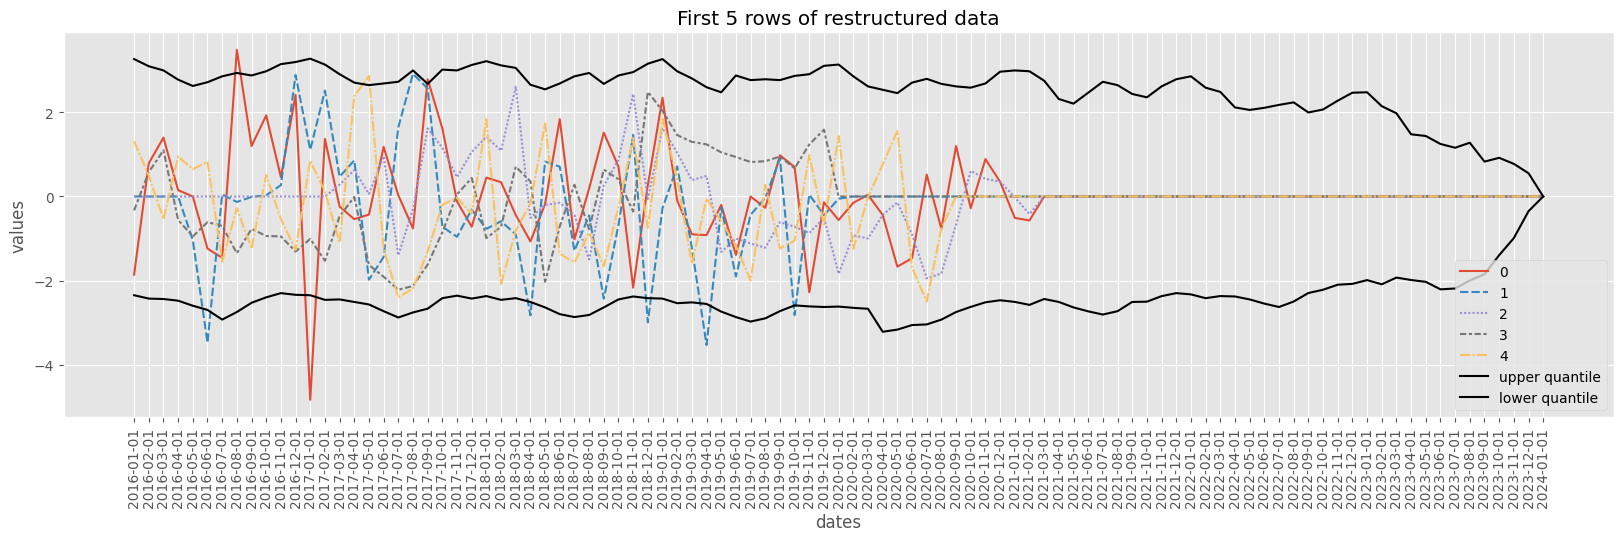

In [63]:
plt.figure(figsize=(20, 5))
sns.lineplot(re_train.iloc[:5, :-1].T)

sns.lineplot(
    re_train.quantile(0.99).iloc[:-1], 
    color='black', 
    label='upper quantile'
)
sns.lineplot(
    re_train.quantile(0.01).iloc[:-1], 
    color='black', 
    label='lower quantile'
)

plt.xlabel('dates')
plt.ylabel('values')
plt.xticks(rotation=90)
plt.title('First 5 rows of restructured data')

plt.show()

Как видим, значения не сильно выбиваются из своих квантилей, так что чистить их от выбросов. С 2023 года квантили начинают опускаться до нуля, это значит, что нужно проверить данные на "разреженность", то есть узнать количество нулевых значений в каждой дате.

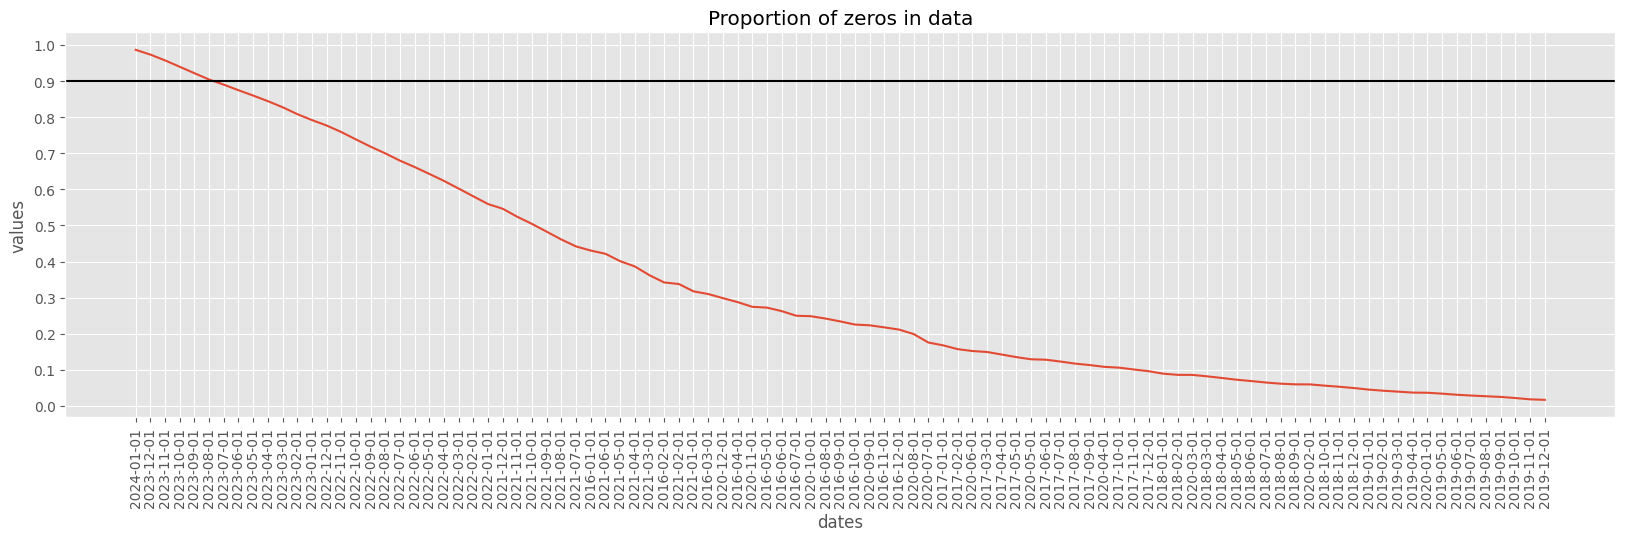

In [64]:
zeros = (
    re_train.drop('label', axis=1) == 0
    ).sum().div(re_train.shape[0]).sort_values(ascending=False)

plt.figure(figsize=(20, 5))
sns.lineplot(zeros)

plt.axhline(0.9, color='black')

plt.xlabel('dates')
plt.ylabel('values')
plt.xticks(rotation=90)
plt.yticks([i/10 for i in range(11)])
plt.title('Proportion of zeros in data')

plt.show()

Даты, в которых более 90% значений нулевые лучше убрать из таблицы вообще, они не несут полезной информации.

In [65]:
zero_dates = zeros[zeros >= 0.9].index

re_train.drop(
    zero_dates, 
    axis=1, 
    inplace=True
)

    
re_train.shape

(80000, 92)

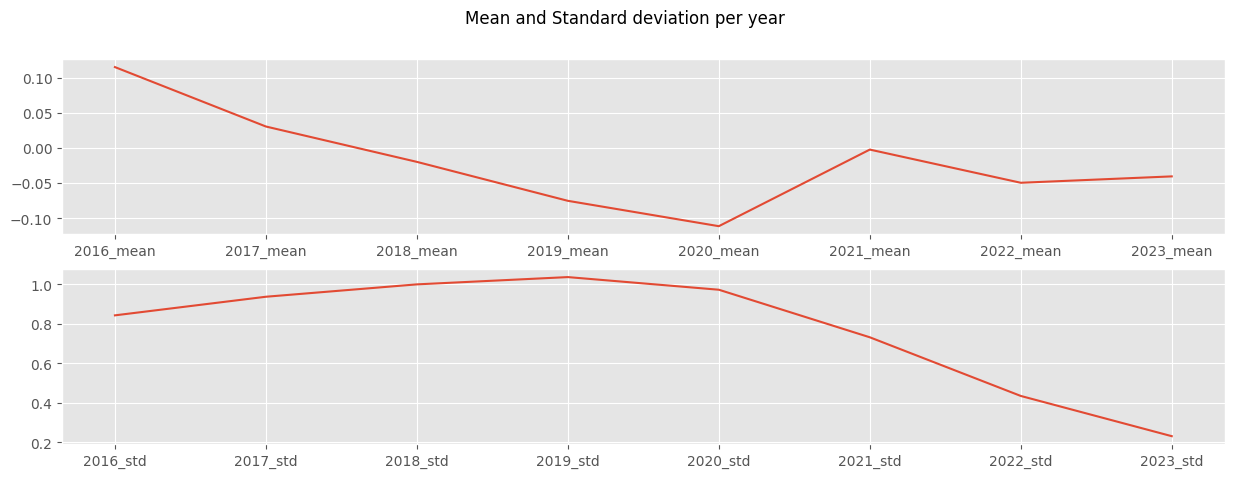

In [66]:
def get_aggs(data):
    if 'label' in data.columns:
        dates = data.drop('label', axis=1) 
    else:
        dates = data
        
    years = set(pd.to_datetime(dates.columns).year)
    
    annuals = []
    stats = pd.DataFrame(index=data.index)
    
    for year in years:
        for col in dates.columns:
            if str(year) in col:
                annuals.append(dates[col])
                
        annual_mean = pd.DataFrame(annuals).T.mean(axis=1)
        annual_mean.name = str(year)+'_mean'
        
        annual_std = pd.DataFrame(annuals).T.std(axis=1)
        annual_std.name = str(year)+'_std'
        
        stats = pd.concat([stats, annual_mean, annual_std], axis=1)
                
        annuals.clear()
    
    data = pd.concat([data, stats], axis=1)
    
    return data


re_train = get_aggs(re_train)

mean_cols = []
std_cols = []

for col in re_train.columns:
    if '_mean' in col:
        mean_cols.append(col)
    if '_std' in col:
        std_cols.append(col)


fig, ax = plt.subplots(2, 1)

sns.lineplot(re_train.loc[:100, mean_cols].mean(), ax=ax[0])
sns.lineplot(re_train.loc[:100, std_cols].mean(), ax=ax[1])

fig.suptitle('Mean and Standard deviation per year')
fig.show()

На первый взгляд, в наших временных рядах нет ни тренда, ни сезонности, но будет лучше, если мы все-таки проверим это с помощью теста Дики-Фуллера на стационарность. 

In [50]:
def get_stationarity(data):
    st_list = []

    print('Objects tested:')
    for i in data.index:
        try:
            adfuller_result = adfuller(
                data.loc[i]
            )
        except ValueError:
            continue
        
        stat = adfuller_result[0]
        pv = adfuller_result[4]['5%']
        
        if stat > pv:
            st_list.append(0)
        else:
            st_list.append(1)
        
        stdout.write(f"\r{i+1}")
        stdout.flush()
        sleep(0.00001)
    print('\n')

    st_coef = sum(st_list) / data.shape[0]
    
    return st_coef


print('Stationarity coefficient:', get_stationarity(re_train))

Objects tested:
80000

Stationarity coefficient: 0.727075


Коэффициент стационарности показывает, что более чем четверть рядов имеет тренд и/или сезонность.

# ML

Перед этапом обучения нужно разделить выборку на тренировочную и валидационную. Для этого необходимо узнать, насколько классы сбалансированы.

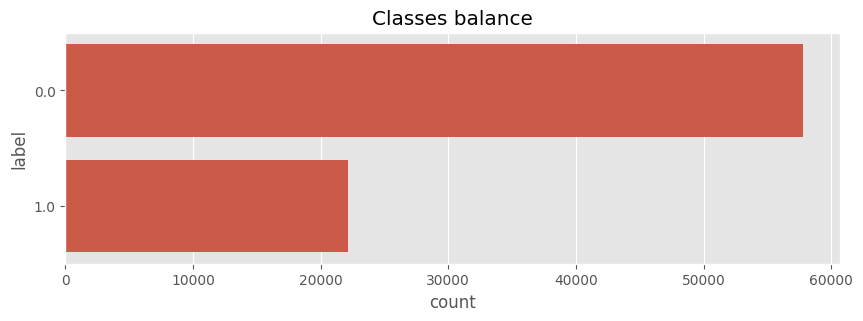

In [51]:
plt.figure(figsize=(10, 3))
sns.barplot(re_train['label'].value_counts(), orient='h')

plt.title('Classes balance')
plt.show()

Классы явно несбалансированы, поэтому при разделении данных выборки нужно стратифицировать.

In [52]:
y = re_train.pop('label')

X_train, X_valid, y_train, y_valid = train_test_split(
    re_train, y, 
    test_size=0.3, 
    random_state=33, 
    stratify=y
)

data_pool = X_train, X_valid, y_train, y_valid

X_train.shape[0], X_valid.shape[0]

(56000, 24000)

In [53]:
def calc_rocauc(model, X, y):
    proba = model.predict_proba(X)[:, 1]
    rocauc = roc_auc_score(y, proba)
    
    return round(rocauc, 2)

def estimate_model(model):
    rocauc_train = calc_rocauc(model, X_train, y_train)
    rocauc_valid = calc_rocauc(model, X_valid, y_valid)

    print('')
    print('Train ROC AUC: ', rocauc_train)
    print('Valid ROC AUC: ', rocauc_valid)


baseline = LogisticRegression()
baseline.fit(X_train, y_train)

estimate_model(baseline)


Train ROC AUC:  0.84
Valid ROC AUC:  0.84


In [54]:
xgb = XGBClassifier(
        objective='binary:logistic',
        eval_metric='auc', 
        early_stopping_rounds=5, 
        random_state=33
)

xgb.fit(X_train, 
        y_train, 
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        verbose=10)

estimate_model(xgb)

[0]	validation_0-auc:0.73908	validation_1-auc:0.72580
[10]	validation_0-auc:0.87352	validation_1-auc:0.84356
[20]	validation_0-auc:0.90673	validation_1-auc:0.86222
[30]	validation_0-auc:0.92708	validation_1-auc:0.87184
[40]	validation_0-auc:0.94033	validation_1-auc:0.87643
[50]	validation_0-auc:0.95018	validation_1-auc:0.87969
[60]	validation_0-auc:0.95782	validation_1-auc:0.88190
[70]	validation_0-auc:0.96385	validation_1-auc:0.88286
[80]	validation_0-auc:0.96857	validation_1-auc:0.88428
[90]	validation_0-auc:0.97335	validation_1-auc:0.88542
[99]	validation_0-auc:0.97659	validation_1-auc:0.88577

Train ROC AUC:  0.98
Valid ROC AUC:  0.89


In [55]:
def opt_xgb(trial): 
    model = XGBClassifier(
        learning_rate = trial.suggest_float('learning_rate', 1e-5, 1), 
        max_depth = trial.suggest_int('max_depth', 2, 10),
        subsample = trial.suggest_float('subsample', 0.1, 1),
        colsample_bynode = trial.suggest_float('colsample_bynode', 0.1, 1),
        reg_lambda = trial.suggest_int('reg_lambda', 1, 100), 
        objective='binary:logistic',
        eval_metric='auc', 
        early_stopping_rounds=5, 
        random_state=33
    )
    model.fit(
        X_train, 
        y_train, 
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        verbose=0
    )
    
    rocauc_train = calc_rocauc(model, X_train, y_train)
    rocauc_valid = calc_rocauc(model, X_valid, y_valid)
    rocauc_diff = abs(rocauc_train-rocauc_valid)
    
    return rocauc_valid, round(rocauc_diff, 2)


xgb_study = optuna.create_study(
    study_name='XGBoost', 
    directions=['maximize', 'minimize']
)

xgb_study.optimize(opt_xgb, n_trials=100)

[I 2024-10-23 18:07:36,218] A new study created in memory with name: XGBoost
[I 2024-10-23 18:07:38,765] Trial 0 finished with values: [0.88, 0.05] and parameters: {'learning_rate': 0.6944000364693788, 'max_depth': 4, 'subsample': 0.9028814384937055, 'colsample_bynode': 0.22420874915053696, 'reg_lambda': 20}. 
[I 2024-10-23 18:07:41,374] Trial 1 finished with values: [0.8, 0.0] and parameters: {'learning_rate': 0.023947316366363162, 'max_depth': 4, 'subsample': 0.14399409395896887, 'colsample_bynode': 0.30826631624605333, 'reg_lambda': 75}. 
[I 2024-10-23 18:07:44,399] Trial 2 finished with values: [0.89, 0.04] and parameters: {'learning_rate': 0.3339630944107204, 'max_depth': 5, 'subsample': 0.6719843637165629, 'colsample_bynode': 0.9854611637016292, 'reg_lambda': 83}. 
[I 2024-10-23 18:07:46,545] Trial 3 finished with values: [0.84, 0.01] and parameters: {'learning_rate': 0.6557396825303685, 'max_depth': 2, 'subsample': 0.11348888919567303, 'colsample_bynode': 0.2832415234514106, 're

In [56]:
xgb_best_trials = xgb_study.best_trials

xgb_df = pd.DataFrame()
xgb_params = {}

for n, trial in enumerate(xgb_best_trials):
    xgb_df.loc[n, 'score'] = trial.values[0]
    xgb_df.loc[n, 'diff'] = trial.values[1]
    xgb_df.loc[n, 'number'] = trial.number
    xgb_params[trial.number] = trial.params
    
best_trial = xgb_df.sort_values(by=['score', 'diff'], ascending=False).iloc[0]

best_trial

score     0.89
diff      0.04
number    2.00
Name: 0, dtype: float64

In [57]:
best_params = xgb_params[best_trial['number']]

xgb_opt = XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc', 
    early_stopping_rounds=5, 
    random_state=33
    ).set_params(**best_params)

xgb_opt.fit(
    X_train, 
    y_train, 
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    verbose=10
)

estimate_model(xgb_opt)

[0]	validation_0-auc:0.70028	validation_1-auc:0.69515
[10]	validation_0-auc:0.84080	validation_1-auc:0.83060
[20]	validation_0-auc:0.87034	validation_1-auc:0.85501
[30]	validation_0-auc:0.88445	validation_1-auc:0.86370
[40]	validation_0-auc:0.89450	validation_1-auc:0.87041
[50]	validation_0-auc:0.90292	validation_1-auc:0.87501
[60]	validation_0-auc:0.90909	validation_1-auc:0.87877
[70]	validation_0-auc:0.91451	validation_1-auc:0.88137
[80]	validation_0-auc:0.91851	validation_1-auc:0.88289
[90]	validation_0-auc:0.92270	validation_1-auc:0.88492
[99]	validation_0-auc:0.92638	validation_1-auc:0.88670

Train ROC AUC:  0.93
Valid ROC AUC:  0.89


In [58]:
with open('final/model.pkl', 'wb') as model_file:
    pkl.dump(xgb_opt, model_file)
    
print(xgb_opt)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=0.9854611637016292,
              colsample_bytree=None, device=None, early_stopping_rounds=5,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3339630944107204,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=33, ...)


In [68]:
re_test.drop(zero_dates, axis=1, inplace=True)
re_test = get_aggs(re_test)

re_test.to_csv('final/data.csv', index=False)